## Xiao Luo, luoxiaoustc@gmail.com, https://github.com/playbar12641/machinelearningtools

## This workflow is a simple demonstration of artificial neural net using tensor flow


### Credit to Dr. Michael Pyrcz (https://github.com/GeostatsGuy)
 
Before start, please make sure that geostatspy and tensorflow are installed.

First, let us load some basic packages

In [1]:
import geostatspy.GSLIB as GSLIB          # 
import geostatspy.geostats as geostats    # the geostatspy is needed for visualization 

import numpy as np                        # basic data calculation
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
from sklearn.model_selection import train_test_split # train / test split

We also need keras from tensorflow for neural network models

In [2]:
import tensorflow as tf
tf.__version__               # check the installed version of tensorflow
from tensorflow import keras

Now, we load the necessary packages, let us load data

## 1. Set working directory

#### *note that the working direction is subject to change.

In [4]:
path=os.path.expanduser("~\\Box\\XL")
# get the relative path to the user directory
os.chdir(path) # set the working directory

## 2. Load and check data
load the well data (credit to Dr. Pyrcz), the data contains
* X and Y coordinates ($m$)
* rock facies (0 for shale and 1 for sand) 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 

In [11]:
df = pd.read_csv('12_sample_data.csv')     # load the well data 
df = df.sample(frac=.30, random_state = 73073); # just randomly select 30% of the data from the csv file 
df = df.reset_index() 
df['logPerm'] = np.log10(df['Perm'].values); # convert Perm to log scale
df['Facies_Label']=np.zeros(len(df));
df['Facies_Label']= np.where(df['Facies']==1, 'Sand', 'Shale') # label the facies 0 for shale and 1 for sand

After loading the data, let us view it in table form

In [12]:
df.head(n=13) #view the data in tabular form

,index,X,Y,Facies,Porosity,Perm,AI,logPerm,Facies_Label
0,72,250,50,0,0.139637,0.347182,4747.274043,-0.459442,Shale
1,153,650,750,0,0.170732,10.720560,4535.625583,1.030217,Shale
2,258,80,669,1,0.244345,3222.716042,2696.102930,3.508222,Sand
3,56,200,150,0,0.167125,3.042590,5500.997419,0.483243,Shale
4,303,60,929,1,0.216253,400.298484,3959.934912,2.602384,Sand
5,374,750,699,0,0.159171,9.224292,5263.064063,0.964933,Shale
6,333,340,549,0,0.170881,84.471492,2918.232227,1.926710,Shale
7,1,50,850,1,0.237154,39.837129,3074.562617,1.600288,Sand
8,54,200,250,1,0.188043,57.804784,4997.078597,1.761964,Sand
9,311,250,579,1,0.215039,625.510541,2693.691341,2.796235,Sand


Also, get the summary statistics, just to make sure the input data looks good.

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,144.0,261.048611,136.830267,1.000000,144.750000,270.000000,381.250000,478.000000
X,144.0,449.375000,263.691435,0.000000,242.500000,400.000000,650.000000,980.000000
Y,144.0,542.979167,289.228936,19.000000,300.000000,579.000000,800.000000,979.000000
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.190700,0.031972,0.131230,0.166621,0.188733,0.217234,0.256172
Perm,144.0,510.036736,1136.459068,0.039555,6.950509,56.886770,356.658709,7452.343369
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653
logPerm,144.0,1.646059,1.210694,-1.402796,0.841941,1.754955,2.552252,3.872293


From the overall statistics, I can specify max and min for these properties. They will become useful when plotting. 

In [17]:
# credit to Dr. Pyrcz
pormin = 0.13; pormax = 0.26              # porosity min and max
permmin = 0.01; permmax = 3000            # permeability min and max
AImin = 1000.0; AImax = 8000              # acoustic impedance min and max
Fmin = 0; Fmax = 1                        # facies min and max
cmap = plt.cm.plasma                      # color map for plotting

In addition to the well data, also load the seismic data (credit to Dr. Pyrcz ) to visulize the entire field. The seismic data is a 2D array/matrix (100 by 100).

In [18]:
seismic = np.loadtxt(open("12_AI.csv", "rb"), delimiter=",")

Let us visualize the field. It easier to use geostatspy. 

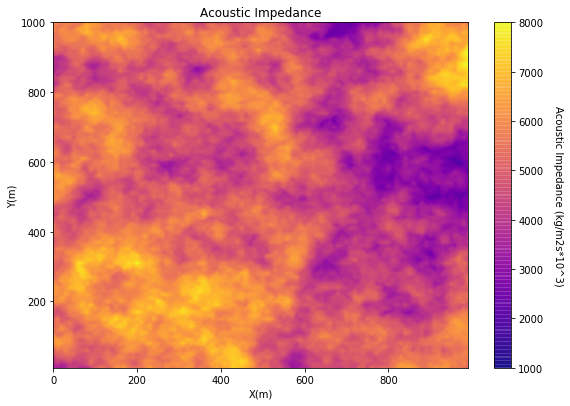

In [21]:
xmin = 0.0; xmax = 1000.0                 # range of x values
ymin = 0.0; ymax = 1000.0                 # range of y values
ny = 100; nx = 100                        # number of cell in Y and X
cell_size = 10.0;                         # grid cell size

plt.subplot(111)
GSLIB.pixelplt_st(seismic,xmin,xmax,ymin,ymax,cell_size,AImin,AImax,'Acoustic Impedance','X(m)','Y(m)','Acoustic Impedance (kg/m2s*10^3)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In this data set, the most important features are facies, porosity, permeability, and acoustic impedance (AI). Let us generate a subset with these features.

In [22]:
df_subset = df.iloc[:,[3,4,7,6]]
df_subset.head(n=13) # let us preview the subset to make sure it is good to go

,Facies,Porosity,logPerm,AI
0,0,0.139637,-0.459442,4747.274043
1,0,0.170732,1.030217,4535.625583
2,1,0.244345,3.508222,2696.102930
3,0,0.167125,0.483243,5500.997419
4,1,0.216253,2.602384,3959.934912
5,0,0.159171,0.964933,5263.064063
6,0,0.170881,1.926710,2918.232227
7,1,0.237154,1.600288,3074.562617
8,1,0.188043,1.761964,4997.078597
9,1,0.215039,2.796235,2693.691341


Often, it is also recommendate to look at the multivariate relationship between the features. We can use seaborn to make a pairplot.

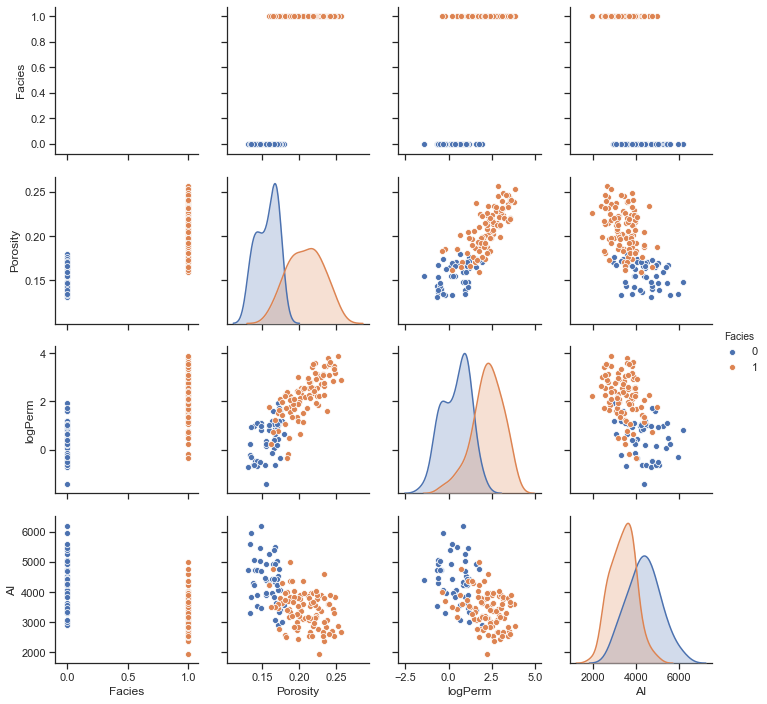

In [24]:
warnings.filterwarnings('ignore')         # supress warning from the seaborn.pairplot         
sns.pairplot(df_subset, hue = 'Facies')
sns.set(style="ticks")
plt.show()

There is a strong correlation between porosity and logperm. But both are relatively weakly dependent on AI. Hence, to prevent multicolinearity and overfit. I will build a machine that predicts porosity based on AI using the well data. To do this, I need to normalize the data to remove the scaling (units) effect.

## 3. Data normalization

In [26]:
# get the minimal and maximum of the features
por_min = df_subset['Porosity'].min(); por_max = df_subset['Porosity'].max();
logperm_min = df_subset['logPerm'].min(); logperm_max = df_subset['logPerm'].max();
AI_min = df_subset['AI'].min(); AI_max = df_subset['AI'].max();

# using a modified minmax scaler so that the data is closer to 0 
df_subset['norm_Porosity'] = (df_subset['Porosity'] - por_min)/(por_max - por_min) * 2 - 1
df_subset['norm_logPerm'] = (df_subset['logPerm'] - logperm_min)/(logperm_max - logperm_min) * 2 - 1
df_subset['norm_AI'] = (df_subset['AI'] - AI_min)/(AI_max - AI_min) * 2 - 1

Have a quick view of the scaled subset 

In [28]:
df_subset.head(n=13)

,Facies,Porosity,logPerm,AI,norm_Porosity,norm_logPerm,norm_AI
0,0,0.139637,-0.459442,4747.274043,-0.865422,-0.642337,0.316178
1,0,0.170732,1.030217,4535.625583,-0.367672,-0.077546,0.216178
2,1,0.244345,3.508222,2696.102930,0.810690,0.861966,-0.652961
3,0,0.167125,0.483243,5500.997419,-0.425413,-0.284926,0.672298
4,1,0.216253,2.602384,3959.934912,0.361002,0.518526,-0.055825
5,0,0.159171,0.964933,5263.064063,-0.552734,-0.102298,0.559879
6,0,0.170881,1.926710,2918.232227,-0.365287,0.262351,-0.548010
7,1,0.237154,1.600288,3074.562617,0.695581,0.138591,-0.474146
8,1,0.188043,1.761964,4997.078597,-0.090559,0.199889,0.434206
9,1,0.215039,2.796235,2693.691341,0.341574,0.592023,-0.654101


Show the summary statistics, all continuous feature should range between -1 to 1

In [29]:
df_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Facies,144.0,0.659722,0.475456,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,144.0,0.190700,0.031972,0.131230,0.166621,0.188733,0.217234,0.256172
logPerm,144.0,1.646059,1.210694,-1.402796,0.841941,1.754955,2.552252,3.872293
AI,144.0,3746.825725,793.196589,1961.600397,3167.631744,3668.526774,4244.264532,6194.573653
norm_Porosity,144.0,-0.048027,0.511789,-1.000000,-0.433483,-0.079520,0.376700,1.000000
norm_logPerm,144.0,0.155945,0.459023,-1.000000,-0.148929,0.197231,0.499519,1.000000
norm_AI,144.0,-0.156515,0.374770,-1.000000,-0.430173,-0.193509,0.078516,1.000000


## 4. Train/test split
After normalization, we need to perform test/train split to the data.

In [31]:
X = df_subset.iloc[:,[6]]                 # extract the predictor feature - acoustic impedance
y = df_subset.iloc[:,[4]]                 # extract the response feature - porosity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73073) # use 20% as testing data

Let us visualize the see if this split is representative. 

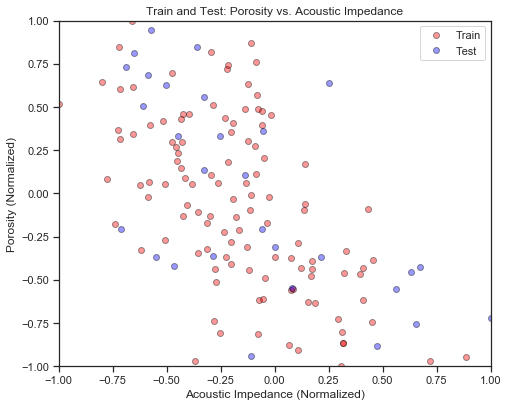

In [32]:
plt.subplot(121)
plt.plot(X_train['norm_AI'].values,y_train['norm_Porosity'].values, 'o', markerfacecolor='red', markeredgecolor='black', alpha=0.4, label = "Train")
plt.plot(X_test['norm_AI'].values,y_test['norm_Porosity'].values, 'o', markerfacecolor='blue', markeredgecolor='black', alpha=0.4, label = "Test")
plt.legend(loc='upper right');
plt.title('Train and Test: Porosity vs. Acoustic Impedance')
plt.ylabel('Porosity (Normalized)')
plt.xlabel('Acoustic Impedance (Normalized)')
plt.xlim(-1,1); plt.ylim(-1,1)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

## 5. Build and train a simple neural network

It is a very simple neural network with only 1 predictor feature (AI), and 1 response (porosity). For the AI at any given location $u$,
\begin{equation}
\phi(\bf{u}) = \hat{f}(AI(\bf{u})).
\end{equation}
This useful to predict the porosity values where the well data is not available.


In [56]:
# Build Neural Network for prediction model (input: AI - > Output: Porosity)
model_1 = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(1,)), # 1 input node
    keras.layers.Dense(10, activation='relu'), # 10 middle node
    keras.layers.Dense(1, activation='tanh'), # 1 output node
])

This neural net has 1 input node, 10 middle layer, and 1 output layer. For more specification, visit https://keras.io/optimizers

In [57]:
keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_1.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

Now, use the normalized data to train the neural network.

In [58]:
hist_1 = model_1.fit(X_train, y_train,
          batch_size=5, epochs=300,
          validation_data=(X_test, y_test))

Train on 115 samples, validate on 29 samples
Epoch 1/300
115/115 [==============================] - 0s 2ms/sample - loss: 0.2307 - accuracy: 0.0000e+00 - val_loss: 0.2769 - val_accuracy: 0.0000e+00
Epoch 2/300
115/115 [==============================] - 0s 200us/sample - loss: 0.2084 - accuracy: 0.0000e+00 - val_loss: 0.2554 - val_accuracy: 0.0000e+00
Epoch 3/300
115/115 [==============================] - 0s 218us/sample - loss: 0.1947 - accuracy: 0.0000e+00 - val_loss: 0.2379 - val_accuracy: 0.0000e+00
Epoch 4/300
115/115 [==============================] - 0s 228us/sample - loss: 0.1849 - accuracy: 0.0000e+00 - val_loss: 0.2232 - val_accuracy: 0.0000e+00
Epoch 5/300
115/115 [==============================] - 0s 213us/sample - loss: 0.1772 - accuracy: 0.0000e+00 - val_loss: 0.2163 - val_accuracy: 0.0000e+00
Epoch 6/300
115/115 [==============================] - 0s 253us/sample - loss: 0.1714 - accuracy: 0.0000e+00 - val_loss: 0.2101 - val_accuracy: 0.0000e+00
Epoch 7/300
115/115 [======

115/115 [==============================] - 0s 174us/sample - loss: 0.1492 - accuracy: 0.0000e+00 - val_loss: 0.2171 - val_accuracy: 0.0000e+00
Epoch 54/300
115/115 [==============================] - 0s 190us/sample - loss: 0.1495 - accuracy: 0.0000e+00 - val_loss: 0.2169 - val_accuracy: 0.0000e+00
Epoch 55/300
115/115 [==============================] - 0s 185us/sample - loss: 0.1495 - accuracy: 0.0000e+00 - val_loss: 0.2188 - val_accuracy: 0.0000e+00
Epoch 56/300
115/115 [==============================] - 0s 194us/sample - loss: 0.1493 - accuracy: 0.0000e+00 - val_loss: 0.2170 - val_accuracy: 0.0000e+00
Epoch 57/300
115/115 [==============================] - 0s 188us/sample - loss: 0.1491 - accuracy: 0.0000e+00 - val_loss: 0.2174 - val_accuracy: 0.0000e+00
Epoch 58/300
115/115 [==============================] - 0s 180us/sample - loss: 0.1494 - accuracy: 0.0000e+00 - val_loss: 0.2164 - val_accuracy: 0.0000e+00
Epoch 59/300
115/115 [==============================] - 0s 184us/sample - los

115/115 [==============================] - 0s 175us/sample - loss: 0.1475 - accuracy: 0.0000e+00 - val_loss: 0.2212 - val_accuracy: 0.0000e+00
Epoch 106/300
115/115 [==============================] - 0s 189us/sample - loss: 0.1475 - accuracy: 0.0000e+00 - val_loss: 0.2183 - val_accuracy: 0.0000e+00
Epoch 107/300
115/115 [==============================] - 0s 185us/sample - loss: 0.1471 - accuracy: 0.0000e+00 - val_loss: 0.2190 - val_accuracy: 0.0000e+00
Epoch 108/300
115/115 [==============================] - 0s 190us/sample - loss: 0.1473 - accuracy: 0.0000e+00 - val_loss: 0.2177 - val_accuracy: 0.0000e+00
Epoch 109/300
115/115 [==============================] - 0s 181us/sample - loss: 0.1473 - accuracy: 0.0000e+00 - val_loss: 0.2188 - val_accuracy: 0.0000e+00
Epoch 110/300
115/115 [==============================] - 0s 176us/sample - loss: 0.1473 - accuracy: 0.0000e+00 - val_loss: 0.2202 - val_accuracy: 0.0000e+00
Epoch 111/300
115/115 [==============================] - 0s 171us/sample

115/115 [==============================] - 0s 191us/sample - loss: 0.1450 - accuracy: 0.0000e+00 - val_loss: 0.2208 - val_accuracy: 0.0000e+00
Epoch 158/300
115/115 [==============================] - 0s 176us/sample - loss: 0.1452 - accuracy: 0.0000e+00 - val_loss: 0.2218 - val_accuracy: 0.0000e+00
Epoch 159/300
115/115 [==============================] - 0s 182us/sample - loss: 0.1452 - accuracy: 0.0000e+00 - val_loss: 0.2232 - val_accuracy: 0.0000e+00
Epoch 160/300
115/115 [==============================] - 0s 183us/sample - loss: 0.1447 - accuracy: 0.0000e+00 - val_loss: 0.2216 - val_accuracy: 0.0000e+00
Epoch 161/300
115/115 [==============================] - 0s 176us/sample - loss: 0.1447 - accuracy: 0.0000e+00 - val_loss: 0.2207 - val_accuracy: 0.0000e+00
Epoch 162/300
115/115 [==============================] - 0s 174us/sample - loss: 0.1448 - accuracy: 0.0000e+00 - val_loss: 0.2215 - val_accuracy: 0.0000e+00
Epoch 163/300
115/115 [==============================] - 0s 181us/sample

115/115 [==============================] - 0s 181us/sample - loss: 0.1432 - accuracy: 0.0000e+00 - val_loss: 0.2240 - val_accuracy: 0.0000e+00
Epoch 210/300
115/115 [==============================] - 0s 176us/sample - loss: 0.1436 - accuracy: 0.0000e+00 - val_loss: 0.2240 - val_accuracy: 0.0000e+00
Epoch 211/300
115/115 [==============================] - 0s 183us/sample - loss: 0.1436 - accuracy: 0.0000e+00 - val_loss: 0.2284 - val_accuracy: 0.0000e+00
Epoch 212/300
115/115 [==============================] - 0s 173us/sample - loss: 0.1429 - accuracy: 0.0000e+00 - val_loss: 0.2244 - val_accuracy: 0.0000e+00
Epoch 213/300
115/115 [==============================] - 0s 181us/sample - loss: 0.1430 - accuracy: 0.0000e+00 - val_loss: 0.2251 - val_accuracy: 0.0000e+00
Epoch 214/300
115/115 [==============================] - 0s 186us/sample - loss: 0.1444 - accuracy: 0.0000e+00 - val_loss: 0.2233 - val_accuracy: 0.0000e+00
Epoch 215/300
115/115 [==============================] - 0s 186us/sample

115/115 [==============================] - 0s 195us/sample - loss: 0.1426 - accuracy: 0.0000e+00 - val_loss: 0.2280 - val_accuracy: 0.0000e+00
Epoch 262/300
115/115 [==============================] - 0s 192us/sample - loss: 0.1421 - accuracy: 0.0000e+00 - val_loss: 0.2257 - val_accuracy: 0.0000e+00
Epoch 263/300
115/115 [==============================] - 0s 172us/sample - loss: 0.1420 - accuracy: 0.0000e+00 - val_loss: 0.2264 - val_accuracy: 0.0000e+00
Epoch 264/300
115/115 [==============================] - 0s 173us/sample - loss: 0.1423 - accuracy: 0.0000e+00 - val_loss: 0.2293 - val_accuracy: 0.0000e+00
Epoch 265/300
115/115 [==============================] - 0s 180us/sample - loss: 0.1423 - accuracy: 0.0000e+00 - val_loss: 0.2272 - val_accuracy: 0.0000e+00
Epoch 266/300
115/115 [==============================] - 0s 178us/sample - loss: 0.1425 - accuracy: 0.0000e+00 - val_loss: 0.2276 - val_accuracy: 0.0000e+00
Epoch 267/300
115/115 [==============================] - 0s 186us/sample

Let us check the training curve to see how fast the model converges.
* this is a measure of the inaccuracy

* **square loss** ($L_2$ loss) is the:

\begin{equation}
L_2 = \sum_{\bf{u}_{\alpha} \in AOI} \left(y(\bf{u}_{\alpha}) - \hat{f}(x_1(\bf{u}_{\alpha}),\ldots,x_m(\bf{u}_{\alpha})\right)
\end{equation}

We can see the progress of the model over epochs in reduction of training and testing error.

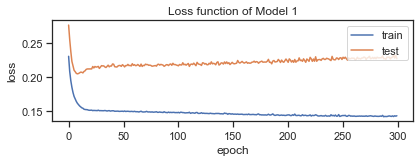

In [59]:
plt.subplot(2,1,1)
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Loss function of Model 1')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

## 6. Making and visualizing predictions
Let us visualize the model in a predictor versus response plot.

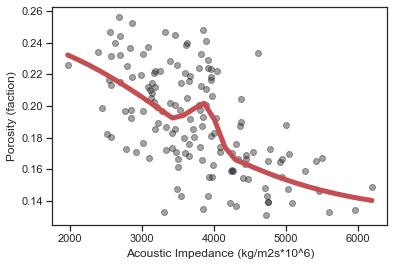

In [60]:
AIbins = np.linspace(df_subset['AI'].values.min(), df_subset['AI'].values.max(), 30) # set the bins for prediction
norm_AIbins = (AIbins-AI_min)/(AI_max-AI_min)*2-1 # use normalized bins

pred_norm_porsity = model_1.predict(np.array(norm_AIbins)) # predict with our ANN

pred_porosity = (pred_norm_porsity + 1)/2*(por_max - por_min)+por_min # transform it back to original range

plt.figure()
plt.plot(df_subset['AI'].values,df_subset['Porosity'].values,'ko', alpha = 0.4)
plt.plot(AIbins,pred_porosity,'r-',linewidth=5)
plt.xlabel('Acoustic Impedance (kg/m2s*10^6)')
plt.ylabel('Porosity (faction)')
plt.show()

Earlier, we have plot the AI for the entire field, now, let us use the neural network to calculate the porosity for the field.

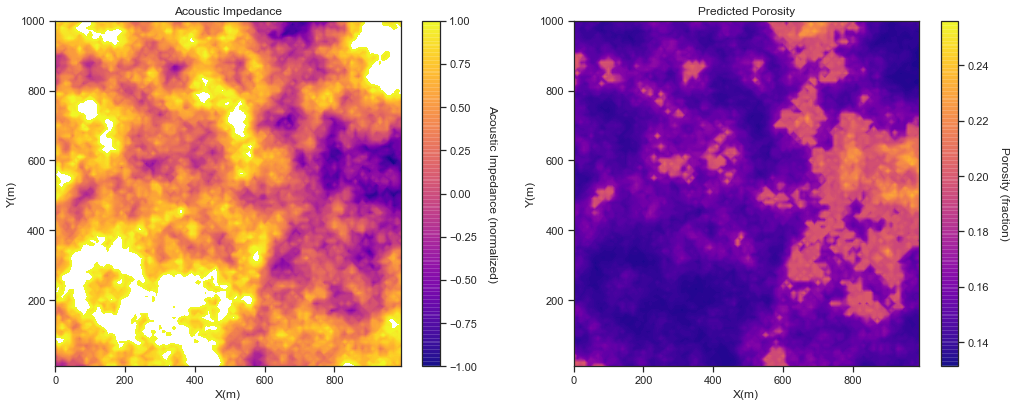

In [61]:
norm_seismic = (seismic-AI_min)/(AI_max-AI_min)*2-1

pred_norm_porosity_map = model_1.predict(np.array(norm_seismic.flatten())) # predict with our ANN

pred_porosity_map = (pred_norm_porosity_map + 1)/2*(por_max - por_min)+por_min # transform it back to original range
pred_porosity_map = np.reshape(pred_porosity_map,(ny,nx))

plt.subplot(121)
GSLIB.pixelplt_st(norm_seismic,xmin,xmax,ymin,ymax,cell_size,-1,1,'Acoustic Impedance','X(m)','Y(m)','Acoustic Impedance (normalized)',cmap)

plt.subplot(122)
GSLIB.pixelplt_st(pred_porosity_map,xmin,xmax,ymin,ymax,cell_size,por_min,por_max,'Predicted Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

## 7. Interogate the neural net

There are some methods available to interogate the artificial neural net.

* neural net summary

* weights

Here's the summary from our neural net.  It lists by layers the number of nodes and number of parameters.

In [62]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


We can also see the actual trained weights for each node in each layer.

In [63]:
# Weights of Model_1

for layer in model_1.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)
    print('\n')

{'name': 'dense_12', 'trainable': True, 'batch_input_shape': (None, 1), 'dtype': 'float32', 'units': 10, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.2304569 ,  0.9653617 , -0.7714542 ,  0.55854106, -0.48583525,
        -0.47624227, -0.6124743 , -0.7693185 ,  0.9053401 ,  0.7019255 ]],
      dtype=float32), array([-0.07264166,  0.01617814,  0.05020705, -0.07789773, -0.15259746,
        0.02387345,  0.03762741,  0.0478625 ,  0.08732828,  0.19397832],
      dtype=float32)]


{'name': 'dense_13', 'trainable': True, 'dtype': 'float32', 'units': 10, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', '

Thank you!

Xiao Luo

Comments: 

This example does not contain the steps for hyperparameter turning. In case it is needed, k-bin method can be used to tune the hyperparameters. What are the hyperparemeters? The number of nodes (input, middle and output), activation function, etc...